---
header-includes:
  - \usepackage{algorithm2e}
---

# Stochastic Descent Langevin Dynamics (SGLD)

In the domain of learning from data $\mathcal{D}$ we generally distinguish between the frequentist and the Bayesian approach. Whilst the frequentist approach assumes one true solution for the model parameters $\boldsymbol{\theta}$ for the problem at hand, being Bayesian models the parameters with a distribution and by this takes uncertainties into account. With the Bayesian approach we can express our knowledge about the model parameters prior of seeing any data. We can also express zero prior knowledge by using a uniform distribution assigning each parameter value the same probability. The more data the model sees, the more certain it is in its parameters, converging to the frequentist estimate when much data is observed.

In the frequentist approach, also called Maximum Likelihood Estimation (MLE), each individual data point of $\mathcal{D}=\{\mathbf{x}_i,y_i\}$ with $N$ data points is modeled with a Gaussian distribution:

$$p(\mathbf{y}_i|\mathbf{x}_i, \boldsymbol{\theta}) = \frac{1}{\sigma\sqrt{2\pi}}\exp \left\{-\frac{1}{2\sigma^2}(y_i -\boldsymbol{\theta}^T\mathbf{x}_i)^2 \right\}$$ ,

where $\boldsymbol{\theta}$ denotes the model parameters. We are assuming a multidimensional output, but only a one-dimensional output for simplicity, though it actually can be of arbitrary dimension. Under the assumption of independent and identically distributed (i.i.d.) data, the probability for all data points factorizes (called the likelihood function):

$$p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta}) = \prod_{i=1}^{N} p(\mathbf{y}_i|\mathbf{x}_i, \boldsymbol{\theta})$$ ,

where $\mathbf{X}$ denotes the matrix of all data points with each data point $\mathbf{x}_i$ as a row vector.

## Markov Chain Monte Carlo Sampling

*A great deal of the following explanations is inspired by the <a href="https://escholarship.org/content/qt4k8039zm/qt4k8039zm.pdf">PhD thesis from Sungjin Ahn</a>.*

Evaluating the posterior becomes intractable even for small models that are non-linear. We reviewed two popular techniques for the simple exmaple of linear regression <a href="">here</a>, variational inference and Markov chain Monte Carlo (MCMC) sampling. As a quick recap, as the name implies MCMC methods combine Markov chains with Monte Carlo (MC) methods. A Markov chain is used to sample from a distribution of interest (e.g. our intractable posterior), and then by employing MC methods we can approximate the expectation whose exact solution is again to expensive to compute. MCMC methods make no assumption about the form of our posterior e.g. as to wether it can be approximated with a multivariate Gaussian. They only assume the posterior $p(\boldsymbol{\theta}|\mathcal{D})$ can be calculated up to normalization constant $Z$ meaning $p(\boldsymbol{\theta}|\mathcal{D})=\tilde{p}(\boldsymbol{\theta}|\mathcal{D})/Z$, where $Z$ denotes the evidence in our case (<a href="http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf">Bishop 2006</a>).

### Monte Carlo Integration

In machine learning we are often interested in computing an expectation of a function $\mathbb{E}\left[\mathbf{f}_{\boldsymbol{\theta}}\right]$ w.r.t. a distribution of the model parameters $p(\boldsymbol{\theta})$. In our case the distribution is defined by the posterior of our parameters $p(\boldsymbol{\theta}|\mathcal{D})$. Computing the expectation involves computing an integral, but we use Monte Carlo integration to approximate that integral by sampling from our posterior:

$$
\begin{aligned}
\mathbb{E}(\mathbf{f}) &= \int \mathbf{f}_{\boldsymbol{\theta}}(\mathbf{x}_*)p(\boldsymbol{\theta}|\boldsymbol{\Phi},\mathbf{y})d\boldsymbol{\theta} \\
&\approx \frac{1}{M} \sum_{i=1}^M \mathbf{f}_{\boldsymbol{\theta}_i}(\mathbf{x}_*) \quad \textrm{where} \quad \boldsymbol{\theta}_i \sim p(\boldsymbol{\theta}|\mathcal{D}) ~.
\end{aligned}
$$

The MC estimator is unbiased and consistent because by the <a href="https://en.wikipedia.org/wiki/Law_of_large_numbers#:~:text=Strong%20law,-The%20strong%20law&text=What%20this%20means%20is%20that,that%20of%20the%20weak%20law.">strong law of large numbers</a> it almost surely converges to the true value as the number of samples increases. Also, by the <a href="https://en.wikipedia.org/wiki/Central_limit_theorem">central limit theorem</a>, the variance of the MC estimator is 

$$\mathrm{Var}\left[\mathbf{f}\right] = \frac{\mathrm{Var}\left[\mathbf{f}_{\boldsymbol{\theta}_i}\right]}{M}~.$$

Thus, the more samples we analyse, the better our accuracy becomes, if the generated samples from the posterior $\boldsymbol{\theta}_i$ are independent. For complicated posterior distributions this is mostly impossible, but it still gives an unbiased estimate, if the number of generated samples is high enough (<a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.446.9306&rep=rep1&type=pdf">Neal 1996</a>). The question remains of how to draw samples from our target distribution

### Markov Chains

To generate a set of dependent weights $\boldsymbol{\theta}_i$ a Markov chain can be utilized that has
the posterior $p(\boldsymbol{\theta}|\boldsymbol{\Phi},\mathbf{y})$ as its equilibrium distribution. Markov Chains are a sequence of events, where the probability of one event depends only on the state of the previous one. So, one
samples from a proposal distribution $q(\boldsymbol{\theta}|\boldsymbol{\theta}_i)$ and maintains a record of the current state $\boldsymbol{\theta}_i$. A Markov chain is defined by giving an initial distribution for the
first state of the chain $\boldsymbol{\theta}_1$ and a transition distribution for a new state $\boldsymbol{\theta}_{i+1}$ following from the current state $\boldsymbol{\theta}_i$. A stationary distribution q is established if the distribution
given by state $\boldsymbol{\theta}_{i+1}$ is the same as with state $\boldsymbol{\theta}_i$. If the drawn samples are dependent then early drawn samples need to be discarded, since they usually are not representatives
of the equilibrium distribution referred to as burn in phase. If the samples are dependent
the chain also needs much longer to reach its equilibrium distribution (<a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.446.9306&rep=rep1&type=pdf">Neal 1996</a>).

A popular algorithm for MCMC sampling is Metropolis-Hastings (<a href="https://bayes.wustl.edu/Manual/EquationOfState.pdf">Metropolis et al. 1953</a>, <a href="https://academic.oup.com/biomet/article-abstract/57/1/97/284580?redirectedFrom=fulltext">Hastings 1970</a>). The acceptance probability Ai at time step i is given by

$$A_i(\boldsymbol{\theta}_*,\boldsymbol{\theta}_i) = \textrm{min} \left( 1, \frac{q(\boldsymbol{\theta}_i|\boldsymbol{\theta}_*)\tilde{p}(\boldsymbol{\theta}_*)}{q(\boldsymbol{\theta}_*|\boldsymbol{\theta}_i)\tilde{p}(\boldsymbol{\theta}_i)}  \right) ~,$$

where $\boldsymbol{\theta}_i$ denotes the current state and $\boldsymbol{\theta}_*$ the drawn proposal state, $\tilde{p}(\boldsymbol{\theta})$ is the prior of the model parameters. The normalization constants cancel out each other. After the acceptance probability is calculated, a random number $r$ is drawn from a Uniform distribution $r \sim \mathcal{U}(0,1)$. If $A_i > r$ the proposal state is accepted. 

\begin{algorithm}
\SetAlgoLined
\KwResult{Write here the result }
 initialization\;
 \While{While condition}{
  instructions\;
  \eIf{condition}{
   instructions1\;
   instructions2\;
   }{
   instructions3\;
  }
 }
 \caption{How to write algorithms}
\end{algorithm}

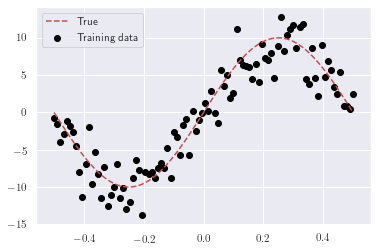

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
import torch

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

def f(x: torch.Tensor, sigma: float) -> torch.Tensor:
    epsilon = torch.randn(*x.shape) * sigma
    return 10 * torch.sin(2 * np.pi * (x)) + epsilon.to(x.device)

train_size = 96
sigma = 2.0

x = torch.linspace(-0.5, 0.5, train_size).reshape(-1, 1).type(dtype)
y = f(x, sigma=sigma).type(dtype)
y_true = f(x, sigma=0.0)

plt.scatter(x.cpu(), y.cpu(), color='black', label='Training data')
plt.plot(x.cpu(), y_true.cpu(), label='True', color='r', linestyle='--')
plt.legend()
plt.show()

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    
    def __init__(self, in_features: int = 1, out_features: int = 1):
        super(Model, self).__init__()
        
        self.layer1 = nn.Linear(in_features, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, out_features)
    
    def forward(self, x: torch.Tensor) -> (torch.Tensor):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [3]:
from typing import Generator
from torch.optim import Optimizer

class SGLD(Optimizer):

    def __init__(self, params: Generator[torch.Tensor, None, None], lr: float, weight_decay: float = 0., 
                 glr: str = 'var'):

        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, weight_decay=weight_decay)
        self.glr = glr

        super(SGLD, self).__init__(params, defaults)

    def step(self) -> torch.Tensor:

        loss = None

        for group in self.param_groups:

            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p += weight_decay * p.data
                
                langevin_noise = torch.empty(p.data.size()).normal_().to(d_p.device)
                if self.glr == 'var':
                    p.data += -group['lr'] * 0.5 * d_p + np.sqrt(group['lr']) * langevin_noise
                else:
                    p.data += -group['lr'] * 0.5 * d_p + group['lr'] * langevin_noise

        return loss

In [4]:
def gaussian_nll(mu: torch.Tensor, logvar: torch.Tensor, target: torch.Tensor, 
                 reduction: str = 'mean') -> torch.Tensor:
    loss = torch.exp(-logvar) * torch.pow(target - mu, 2) + logvar
    return loss.mean() if reduction=='mean' else loss.sum()

def calc_uncert(preds: [torch.Tensor], reduction: str = 'mean') -> (torch.Tensor, torch.Tensor, torch.Tensor):
    preds = torch.cat(preds, dim=0)
    epi = torch.var(preds[:,:,0], dim=0)
    ale = torch.mean(preds[:,:,1], dim=0)#.exp()
    uncert = ale + epi
    if reduction == 'mean':
        return ale.mean(), epi.mean(), uncert.mean()
    else:
        return ale, epi, uncert

In [5]:
from typing import Callable
from copy import deepcopy
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from torch.optim import lr_scheduler, Adam

def train(model: nn.Module, loss_fct: Callable, x: torch.Tensor, y: torch.Tensor, 
          batch_size: int = 1, optim: Optimizer = SGLD, burnin_iter: int = 0, mcmc_iter: int = 50, glr: str = 'var',
          weight_decay: float = 0., lr: float = 1e-3, num_epochs: int = 1000, gamma: float = 0.996) -> (list):

    losses, models = [], []
    
    optim = optim(model.parameters(), lr=lr, weight_decay=weight_decay, glr=glr)
    lr_sched = lr_scheduler.ExponentialLR(optim, gamma)
    m = int(len(x)/batch_size)
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        idx = torch.randperm(len(x))
        total_loss, total_kl = 0, 0
        for batch_idx in range(1, m+1):
            optim.zero_grad()
            
            out = model(x[idx[(batch_idx-1) * batch_size : batch_idx * batch_size]])

            loss = loss_fct(out, y[idx[(batch_idx-1) * batch_size : batch_idx * batch_size]])

            loss.backward()
            optim.step()
            lr_sched.step()
            
            total_loss += loss.item()
        
        losses.append(total_loss)
        
        if epoch > burnin_iter and epoch % mcmc_iter == 0:
            models.append(deepcopy(model))

        pbar.set_description('loss: %.6f' % total_loss)
    
    return losses, models


def pred(models: [nn.Module], x: torch.Tensor) -> (torch.Tensor):
    
    y_preds = []
    
    with torch.no_grad():
        for model in tqdm(models):
            y_pred = model(x)
            y_preds.append(y_pred.unsqueeze(0))
    
    y_mean = torch.cat(y_preds, dim=0)[:,:,0].mean(dim=0)
    if y_preds[0].shape[-1] > 1:
        ale, epi, uncert = calc_uncert(y_preds, reduction=None)
    else:
        ale = torch.tensor([0.])
        epi = uncert = torch.var(torch.cat(y_preds, dim=0)[:,:,0], dim=0)
    
    return y_mean, ale, epi, uncert


def plot_uncert(x_test: torch.Tensor, y_pred_mean: torch.Tensor, x_train: torch.Tensor, y_train: torch.Tensor, 
                ale: torch.Tensor, epi: torch.Tensor, uncert: torch.Tensor):
    
    x_test, y_pred_mean, x_train, y_train = x_test.cpu(), y_pred_mean.cpu(), x_train.cpu(), y_train.cpu()
    ale, epi, uncert = torch.sqrt(ale.cpu()), torch.sqrt(epi.cpu()), torch.sqrt(uncert.cpu())
    
    no_std = 2
    
    fig, ax = plt.subplots()
    ax.plot(x_test, y_pred_mean, color='#D1895C', label='Predictive mean');
    ax.scatter(x_train, y_train, color='black', label='Training data')
    ax.fill_between(x_test.flatten(), 
                    gaussian_filter1d(y_pred_mean + no_std * (ale + epi), sigma=5),
                    gaussian_filter1d(y_pred_mean - no_std * (ale + epi), sigma=5),
                    color='#6C85B6',
                    alpha=0.3, label='Aleatoric uncertainty')
    ax.fill_between(x_test.flatten(), 
                    gaussian_filter1d(y_pred_mean + no_std * epi, sigma=5), 
                    gaussian_filter1d(y_pred_mean - no_std * epi, sigma=5), 
                    color='#6C85B6',
                    alpha=0.5, label='Epistemic uncertainty')
    ax.set_xlabel(r'$x$', fontsize=17)
    ax.set_ylabel(r'$y$', fontsize=17)
    ax.legend()
    return fig

In [6]:
def init_normal(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0, std=0.1)

def init_uniform(m):
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight, a=-4, b=4)

In [7]:
LR = 1e-4
BATCH_SIZE = 32
BURNIN_ITER = 2000
MCMC_ITER = 100
NUM_MODELS = 10
NUM_EPOCHS = BURNIN_ITER + MCMC_ITER * NUM_MODELS + 1
WEIGHT_DECAY = .1
GAMMA = 1.

In [8]:
model = Model(out_features=1).type(dtype)
model.apply(init_uniform)
loss_fct = lambda out, y : gaussian_nll(out[:,0], out[:,1], y[:,0], 'mean')
_, models = train(model=model, loss_fct=F.mse_loss, x=x, y=y, batch_size=BATCH_SIZE, gamma=GAMMA,
                    burnin_iter=BURNIN_ITER, mcmc_iter=MCMC_ITER, lr=LR, num_epochs=NUM_EPOCHS, weight_decay=WEIGHT_DECAY)

loss: 23.831179: 100%|██████████| 3001/3001 [00:17<00:00, 174.09it/s]


100%|██████████| 10/10 [00:00<00:00, 5103.80it/s]


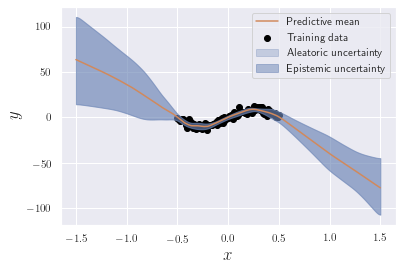

In [9]:
x_test = torch.linspace(-1.5, 1.5, 500).reshape(-1, 1).type(dtype)

y_pred_mean, ale, epi, uncert = pred(models=models, x=x_test)
fig = plot_uncert(x_test=x_test, y_pred_mean=y_pred_mean, x_train=x, y_train=y, 
            ale=ale, epi=epi, uncert=uncert)

In [18]:
model_lr_std = Model(out_features=1).type(dtype)
model_lr_std.apply(init_uniform)
loss_fct = lambda out, y : gaussian_nll(out[:,0], out[:,1], y[:,0], 'mean')
_, models_lr_std = train(model=model_lr_std, loss_fct=F.mse_loss, x=x, y=y, batch_size=BATCH_SIZE, gamma=GAMMA, glr='std',
                        burnin_iter=BURNIN_ITER, mcmc_iter=MCMC_ITER, lr=LR, num_epochs=NUM_EPOCHS, weight_decay=WEIGHT_DECAY)

loss: 14.225636: 100%|██████████| 3001/3001 [00:15<00:00, 189.28it/s]


100%|██████████| 10/10 [00:00<00:00, 4914.24it/s]


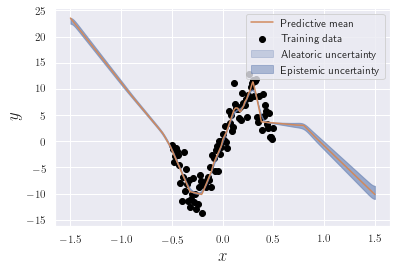

In [19]:
y_pred_mean_lr_std, ale_lr_std, epi_lr_std, uncert_lr_std = pred(models=models_lr_std, x=x_test)
fig = plot_uncert(x_test=x_test, y_pred_mean=y_pred_mean_lr_std, x_train=x, y_train=y, 
            ale=ale_lr_std, epi=epi_lr_std, uncert=uncert_lr_std)